# 0x10 EM Algorithm

In this notebook we will have a hands-on implementation of the Expectation-Maximization (EM) algorithm.

The EM algorithm is a powerful iterative method for finding maximum likelihood estimates of parameters in statistical models with latent (hidden) variables. Many practitioners use libraries that implement EM, but understanding how to write it from scratch gives you deeper insight into how it works.

We'll implement EM for **Gaussian Mixture Models (GMM)**, the classic example for EM algorithm.

In a nutshell, GMM assumes that the data is generated from a mixture of several Gaussian distributions with unknown parameters:

$$
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
$$

and, we would like to estimate the parameters $\{\pi_k, \mu_k, \Sigma_k\}_{k=1}^{K}$ given the observed data $X = \{x_1, x_2, \ldots, x_N\}$.

## 1. The Problem Setup

Now let's reiterate the problem setup.

Suppose you have data points that come from a mixture of K Gaussian distributions, but you don't know which point came from which Gaussian.

You want to estimate:
- The means $\mu_1, \mu_2, ..., \mu_k$
- The variances $\Sigma_1, \Sigma_2, ..., \Sigma_k$
- The mixing weights $\pi_1, \pi_2, ..., \pi_k$

Let's start by generating some synthetic data from known Gaussians, then see if EM can recover the true parameters.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

### Generate synthetic data

We'll create data from 3 Gaussian distributions with different means, variances, and mixing proportions.

In [15]:
# True parameters
true_means = np.array([0.0, 5.0, 10.0])
true_stds = np.array([1.0, 1.5, 0.8])
true_weights = np.array([0.3, 0.4, 0.3])
K = len(true_means)

# Generate data
n_samples = 500
samples = []
true_labels = []

for i in range(n_samples):
    # Choose which Gaussian to sample from
    cluster = np.random.choice(K, p=true_weights)
    # Sample from that Gaussian
    sample = np.random.normal(true_means[cluster], true_stds[cluster])
    samples.append(sample)
    true_labels.append(cluster)

X = np.array(samples)
true_labels = np.array(true_labels)

print(f"Generated {n_samples} samples from {K} Gaussians")

Generated 500 samples from 3 Gaussians


Let's visualize the data. The colors represent the true cluster assignments (which we pretend not to know).

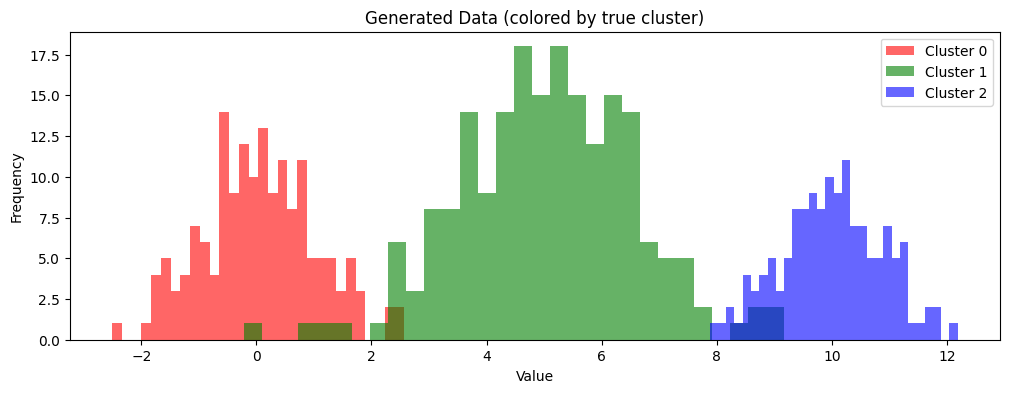

In [16]:
plt.figure(figsize=(12, 4))

# Plot histogram with true labels
colors = ['red', 'green', 'blue']
for k in range(K):
    cluster_data = X[true_labels == k]
    plt.hist(cluster_data, bins=30, alpha=0.6, label=f'Cluster {k}', color=colors[k])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Generated Data (colored by true cluster)')
plt.legend()
plt.show()

## 2. The EM Algorithm

The EM algorithm alternates between two steps:

**E-Step (Expectation)**: For each data point $x_i$ and each cluster k, compute the "responsibility" $\gamma_{ik}$ - the probability that point i belongs to cluster k:

$$\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i | \mu_k, \sigma_k^2)}{\sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i | \mu_j, \sigma_j^2)}$$

**M-Step (Maximization)**: Update the parameters using the responsibilities:

$$N_k = \sum_{i=1}^{n} \gamma_{ik}$$

$$\mu_k = \frac{\sum_{i=1}^{n} \gamma_{ik} \cdot x_i}{N_k}$$

$$\sigma_k^2 = \frac{\sum_{i=1}^{n} \gamma_{ik} \cdot (x_i - \mu_k)^2}{N_k}$$

$$\pi_k = \frac{N_k}{n}$$

We repeat these steps until convergence.

### Why does those steps work?

Let's think of such a procedure that throws away those math abstractions:
- **Expectation**: Make your best guess for this step
- **Maximization**: Using your best guess, update your parameters for the model

And we expect that if we keep repeating those two steps, we will eventually reach a good set of parameters.

The aforementioned process is a specification for this philosophy:
- In the E-step, we make our best guess (soft one, a probability distribution) for the hidden variables (cluster assignments) based on current parameters.
- In the M-step, we update the parameters to maximize the likelihood given our best guess of the hidden variables.

### Implementing the EM Algorithm from Scratch

Here we implement the EM algorithm step by step.

In [ ]:
def gaussian_pdf(x, mu, sigma):
    """Compute Gaussian probability density function."""
    return norm.pdf(x, mu, sigma)

def initialize_parameters(X, K):
    """Initialize parameters randomly."""
    means = np.random.choice(X, K)
    stds = np.ones(K)
    weights = np.ones(K) / K
    return means, stds, weights

def e_step(X, means, stds, weights, K):
    """E-Step: Compute responsibilities."""
    n = len(X)
    responsibilities = np.zeros((n, K))
    
    for k in range(K):
        # Compute probability of each point under Gaussian k
        responsibilities[:, k] = weights[k] * gaussian_pdf(X, means[k], stds[k])
    
    # Normalize to get probabilities (responsibilities)
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    
    return responsibilities

def m_step(X, responsibilities, K):
    """M-Step: Update parameters."""
    n = len(X)
    
    # Effective number of points assigned to each cluster
    N_k = responsibilities.sum(axis=0)
    
    # Update means
    means = (responsibilities.T @ X) / N_k
    
    # Update standard deviations
    stds = np.zeros(K)
    for k in range(K):
        diff = X - means[k]
        stds[k] = np.sqrt((responsibilities[:, k] @ (diff ** 2)) / N_k[k])
    
    # Update weights
    weights = N_k / n
    
    return means, stds, weights

def compute_log_likelihood(X, means, stds, weights, K):
    """Compute log likelihood of the data."""
    n = len(X)
    log_likelihood = 0
    
    for i in range(n):
        likelihood = 0
        for k in range(K):
            likelihood += weights[k] * gaussian_pdf(X[i], means[k], stds[k])
        log_likelihood += np.log(likelihood)
    
    return log_likelihood

### Run the EM Algorithm

In [18]:
# Initialize parameters
means, stds, weights = initialize_parameters(X, K)

print("Initial parameters:")
print(f"Means: {means}")
print(f"Stds: {stds}")
print(f"Weights: {weights}")

# EM iterations
max_iterations = 50
tolerance = 1e-6
log_likelihoods = []

for iteration in range(max_iterations):
    # E-step
    responsibilities = e_step(X, means, stds, weights, K)
    
    # M-step
    means, stds, weights = m_step(X, responsibilities, K)
    
    # Compute log likelihood
    log_likelihood = compute_log_likelihood(X, means, stds, weights, K)
    log_likelihoods.append(log_likelihood)
    
    if iteration % 10 == 0:
        print(f"Iteration {iteration}: Log-Likelihood = {log_likelihood:.2f}")
    
    # Check for convergence
    if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tolerance:
        print(f"\nConverged at iteration {iteration}")
        break

print("\nFinal parameters:")
print(f"Means: {means}")
print(f"Stds: {stds}")
print(f"Weights: {weights}")

print("\nTrue parameters:")
print(f"Means: {true_means}")
print(f"Stds: {true_stds}")
print(f"Weights: {true_weights}")

Initial parameters:
Means: [5.54302087 5.60061804 6.87099058]
Stds: [1. 1. 1.]
Weights: [0.33333333 0.33333333 0.33333333]
Iteration 0: Log-Likelihood = -1362.02
Iteration 10: Log-Likelihood = -1332.71
Iteration 20: Log-Likelihood = -1332.39
Iteration 30: Log-Likelihood = -1331.51
Iteration 40: Log-Likelihood = -1323.90

Final parameters:
Means: [ 0.01667088  5.0594225  10.03598389]
Stds: [0.94607938 1.58459426 0.83550073]
Weights: [0.31864794 0.40637218 0.27497987]

True parameters:
Means: [ 0.  5. 10.]
Stds: [1.  1.5 0.8]
Weights: [0.3 0.4 0.3]


### Visualizing Convergence

Let's plot how the log-likelihood increases during EM iterations.

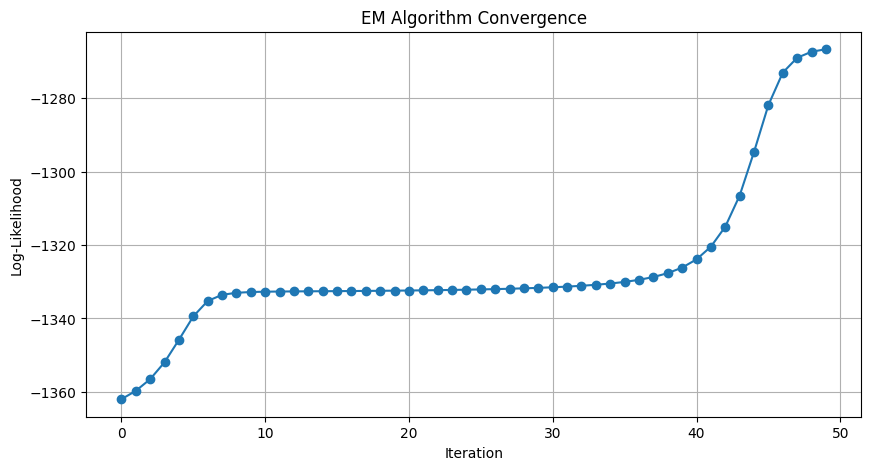

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(log_likelihoods, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

### Visualizing the Learned Distribution

Now let's take a look at how well EM recovered the original Gaussian components.

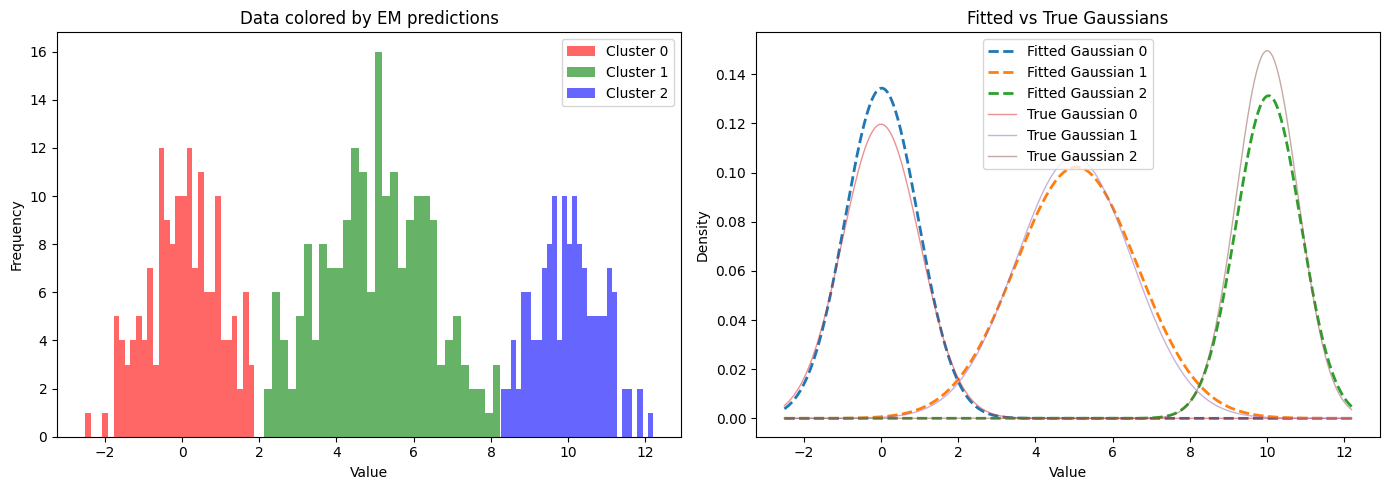

In [20]:
# Get final cluster assignments
final_responsibilities = e_step(X, means, stds, weights, K)
predicted_labels = final_responsibilities.argmax(axis=1)

plt.figure(figsize=(14, 5))

# Plot 1: Data colored by predicted clusters
plt.subplot(1, 2, 1)
for k in range(K):
    cluster_data = X[predicted_labels == k]
    plt.hist(cluster_data, bins=30, alpha=0.6, label=f'Cluster {k}', color=colors[k])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data colored by EM predictions')
plt.legend()

# Plot 2: Fitted Gaussians vs True Gaussians
plt.subplot(1, 2, 2)
x_range = np.linspace(X.min(), X.max(), 1000)

# Plot fitted Gaussians
for k in range(K):
    y = weights[k] * gaussian_pdf(x_range, means[k], stds[k])
    plt.plot(x_range, y, '--', linewidth=2, label=f'Fitted Gaussian {k}')

# Plot true Gaussians
for k in range(K):
    y = true_weights[k] * gaussian_pdf(x_range, true_means[k], true_stds[k])
    plt.plot(x_range, y, '-', linewidth=1, alpha=0.5, label=f'True Gaussian {k}')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Fitted vs True Gaussians')
plt.legend()
plt.tight_layout()
plt.show()

> 🤔 **THINKING**
>
> - Compare the fitted parameters with the true parameters. How close did EM get?
> - Notice that the cluster labels might not match (e.g., EM's cluster 0 might correspond to the true cluster 2). Why is this not a problem?
> - What happens if you run EM with different random initializations? Try it by re-setting the random seed before initializing parameters.

## 3. Comparing with Scikit-learn's Implementation

You may be worried whether we implemented EM correctly. 

Let's compare our results with Scikit-learn's `GaussianMixture` class.

In [21]:
from sklearn.mixture import GaussianMixture

# Fit GMM using sklearn
gmm = GaussianMixture(n_components=K, random_state=42, covariance_type='spherical')
gmm.fit(X.reshape(-1, 1))

print("Sklearn GMM parameters:")
print(f"Means: {gmm.means_.flatten()}")
print(f"Stds: {np.sqrt(gmm.covariances_)}")
print(f"Weights: {gmm.weights_}")

print("\nOur EM parameters:")
print(f"Means: {means}")
print(f"Stds: {stds}")
print(f"Weights: {weights}")

Sklearn GMM parameters:
Means: [9.97417103 0.06435379 5.02807456]
Stds: [0.87921416 0.98189722 1.38759602]
Weights: [0.28746996 0.32816399 0.38436605]

Our EM parameters:
Means: [ 0.01667088  5.0594225  10.03598389]
Stds: [0.94607938 1.58459426 0.83550073]
Weights: [0.31864794 0.40637218 0.27497987]


> 📚 **EXERCISE**
>
> - We assumed K=3, but in real problems you don't know K. Try running EM with different values of K (e.g., K=2, 4, 5). Use the final log-likelihood to compare. Which K seems best? Following this question, how will you select K in practice?
>
> - EM can get stuck in local optima depending on initialization. Are there any better initialization strategies? (Hint: Check K-Means++ initialization)
>
> - Currently we use soft assignments (responsibilities). Modify the algorithm to use hard assignments (assign each point to its most likely cluster). What happens?

In [22]:
# === Your code here ===